In [30]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import os, math
np.random.seed(0)
import warnings
import scipy.stats as st
from datetime import datetime
warnings.filterwarnings('ignore')
import matplotlib.animation as animation

%matplotlib inline

In [11]:
subsample_countries = ["USA"]
dates_processor = lambda x: "{}-01-{}".format(int(x.split("-")[1][1])*3, x.split("-")[0])

# LOAD GDP & NFCI DATA

In [12]:
gdp = pd.read_csv("../data/core/oecd_qrgdp.csv")

gdp = gdp.pivot(index='TIME', columns='LOCATION', values='Value')
gdp.index  = pd.to_datetime(gdp.index.map(dates_processor))
gdp = gdp[subsample_countries]

gdp.dropna(inplace = True)

In [13]:
nfci = pd.read_csv("../data/core/nfci.csv")

nfci["Dates"]  = pd.to_datetime(nfci["Dates"].apply(dates_processor))
nfci.set_index(nfci["Dates"], inplace = True)
nfci = nfci[subsample_countries]

nfci.dropna(inplace = True)

In [14]:
start = max(gdp.index.min(), nfci.index.min())
end = min(gdp.index.max(), nfci.index.max())

print "GDP Growth Data Range: ", gdp.first_valid_index(), gdp.last_valid_index()
print "NFCI Data Range: ", nfci.first_valid_index(), nfci.last_valid_index()
print "USEFUL Data Range: ", start, end

gdp = gdp[start:end]
nfci = nfci[start:end]

GDP Growth Data Range:  1947-06-01 00:00:00 2020-03-01 00:00:00
NFCI Data Range:  1973-03-01 00:00:00 2016-12-01 00:00:00
USEFUL Data Range:  1973-03-01 00:00:00 2016-12-01 00:00:00


In [41]:
def smooth_pdfs(with_nfci, without_nfci,minn, maxx):
    
    with_nfci = st.nct(*st.nct.fit(with_nfci.astype('float64'))).pdf(np.linspace(minn, maxx, 1000))
    without_nfci = st.nct(*st.nct.fit(without_nfci.astype('float64'))).pdf(np.linspace(minn, maxx, 1000))
    output = pd.DataFrame({"NFCI.L1 & GDP.L1":with_nfci, "GDP.L1":without_nfci}, index = np.linspace(minn, maxx, 1000))
    return output

# FIND ONE PERIOD AHEAD QUANTILE

In [16]:
exp_window_start = '1993-03-01'
forecast_horizon = gdp.loc[exp_window_start:].index

In [17]:
Y_GDP = gdp[1:]
X_GDP_L1 = gdp.shift(1)[1:]
X_NFCI_L1 = nfci.shift(1)[1:]

quantiles =[q/500.0 for q in range(1,500)]

#### WITH NFCI

In [29]:
quantile_estimates_with_nfci = pd.DataFrame(columns = forecast_horizon, index = range(1,len(quantiles)+1))

regression_data = pd.DataFrame({"GDP": Y_GDP[subsample_countries[0]], "GDP_L1": X_GDP_L1[subsample_countries[0]],"NFCI_L1": X_NFCI_L1[subsample_countries[0]]})
for forecast_period in forecast_horizon:
    quantile_estimates_with_nfci.loc[500, forecast_period] = regression_data.loc[forecast_period]['GDP']  
    for q in quantiles:
        mod = smf.quantreg('GDP ~ GDP_L1 + NFCI_L1', regression_data.loc[:forecast_period,:]).fit(q=q,max_iter=1000)
        quantile_estimates_with_nfci.loc[int(round(q*500)), forecast_period] = mod.predict(regression_data.loc[forecast_period])[0]

#### WITHOUT NFCI

In [34]:
quantile_estimates_without_nfci = pd.DataFrame(columns = forecast_horizon, index = range(1,len(quantiles)+1))

regression_data = pd.DataFrame({"GDP": Y_GDP[subsample_countries[0]], "GDP_L1": X_GDP_L1[subsample_countries[0]]})
for forecast_period in forecast_horizon:
    quantile_estimates_without_nfci.loc[500, forecast_period] = regression_data.loc[forecast_period]['GDP']  
    for q in quantiles:
        mod = smf.quantreg('GDP ~ GDP_L1 ', regression_data.loc[:forecast_period,:]).fit(q=q,max_iter=1000)
        quantile_estimates_without_nfci.loc[int(round(q*500)), forecast_period] = mod.predict(regression_data.loc[forecast_period])[0]

In [36]:
quantile_estimates_without_nfci.to_csv("usa_500_quantiles_without_nfci.csv")
quantile_estimates_with_nfci.to_csv("usa_500_quantiles_with_nfci.csv")

# MAKE ANIMATION PLOT

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter
import math
%matplotlib inline
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

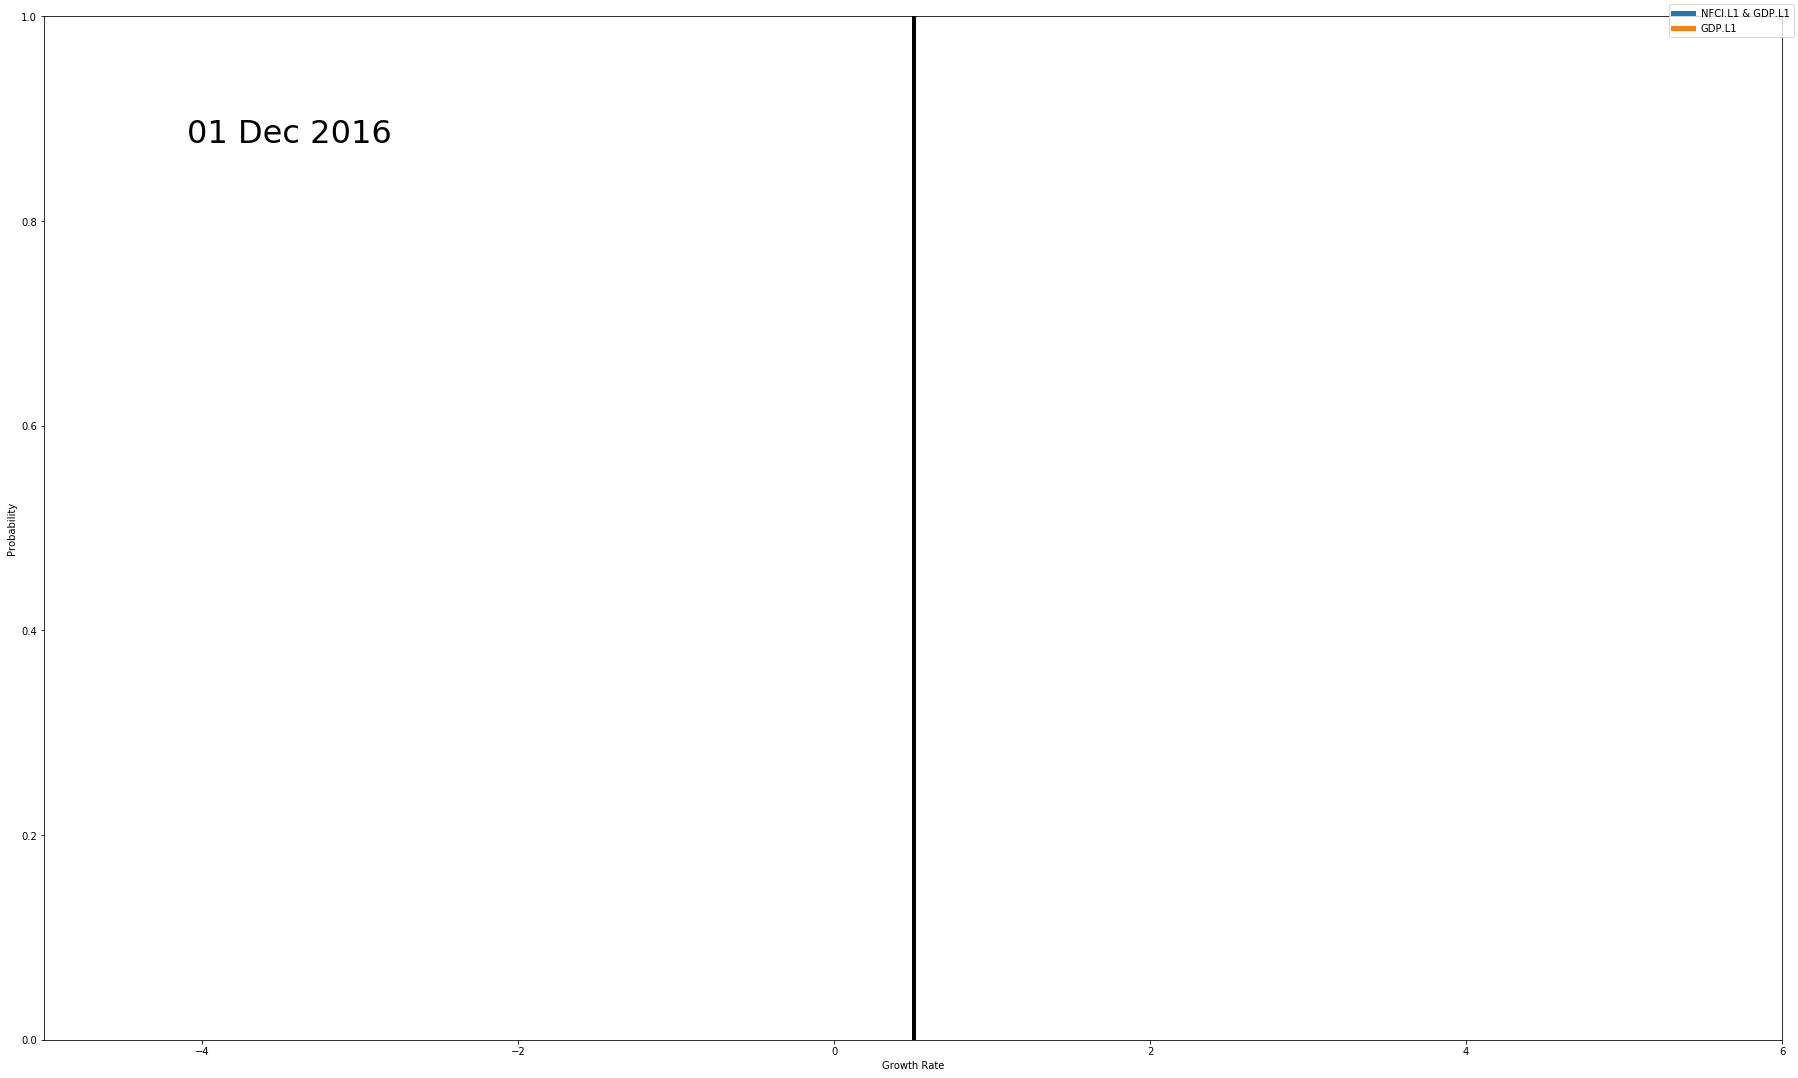

In [77]:
minn = math.floor(min(quantile_estimates_with_nfci.min().min(), quantile_estimates_without_nfci.min().min()))
maxx = math.ceil(max(quantile_estimates_with_nfci.max().max(), quantile_estimates_without_nfci.max().max()))

fig = plt.figure(figsize = (25, 15))
ax = plt.axes(xlim=(minn, maxx), ylim=(0, 1))

with_nfci, = ax.plot([], [], lw=5, label='NFCI.L1 & GDP.L1')
without_nfci, = ax.plot([], [], lw=5, label='GDP.L1')
time_stamp = ax.text(0.2,0.9,'',verticalalignment='top',horizontalalignment='right',transform=ax.transAxes,fontsize=32)
realization = ax.axvline(linewidth=4, color='k')

plt.xlabel('Growth Rate')
plt.ylabel('Probability')


def init():
    with_nfci.set_data([], [])
    without_nfci.set_data([], [])

    return with_nfci, without_nfci

def animate(i):    
    data = smooth_pdfs(quantile_estimates_with_nfci.iloc[:,i][:-1], quantile_estimates_without_nfci.iloc[:,i][:-1], minn, maxx)
    vline = quantile_estimates_with_nfci.iloc[:,i].tail(1)

    with_nfci.set_data(data.index, data['NFCI.L1 & GDP.L1'])
    without_nfci.set_data(data.index, data['GDP.L1'])

    time_stamp.set_text(quantile_estimates_with_nfci.columns[i].strftime("%d %b %Y"))
    realization.set_xdata(vline)
    
    return with_nfci,without_nfci

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=quantile_estimates_with_nfci.shape[1], interval=50)
fig.tight_layout()
fig.legend()

writer = FFMpegWriter(fps=2, bitrate=1800, extra_args=['-vcodec', 'libx264'])
anim.save('basic_animation.mp4', writer = writer)